In [1]:
# Install optuna if not already installed
%pip install optuna

import pandas as pd
import optuna
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import lightgbm as lgb

# Step 1: Load dataset
df = pd.read_csv('water_potability_final.csv')

# Step 2: Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Artificial groups for GroupKFold
groups = np.arange(len(X)) % 5

# Step 3: Train-test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42
)

# Step 4: Define Optuna objective
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1   # Suppress LightGBM split warnings
    }

    model = lgb.LGBMClassifier(**params)
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=gkf.split(X_train, y_train, groups_train),
        scoring='accuracy'
    )
    return scores.mean()

# Step 5: Run optimization (max 30 trials or 30 minutes)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800, show_progress_bar=True)

# Step 6: Train model with best parameters
best_params = study.best_params
lgb_best = lgb.LGBMClassifier(**best_params, random_state=42, verbosity=-1)
lgb_best.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = lgb_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Display results
results = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}])

print("\n Water Potability Model Performance (LGBM):\n", results)
print("\n Best Parameters Found by Optuna:\n", best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.0 MB/s eta 0:00:00


[I 2025-11-16 07:51:02,452] A new study created in memory with name: no-name-dc700447-0b40-438e-88a9-3bb2f6c09517


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-16 07:51:03,024] Trial 0 finished with value: 0.7641755049475666 and parameters: {'n_estimators': 114, 'learning_rate': 0.020288932148351806, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 57, 'subsample': 0.6776244226890962, 'colsample_bytree': 0.8382168388413964, 'reg_lambda': 0.9143339144716844, 'reg_alpha': 0.46307135151755796}. Best is trial 0 with value: 0.7641755049475666.
[I 2025-11-16 07:51:03,750] Trial 1 finished with value: 0.7833942080729706 and parameters: {'n_estimators': 234, 'learning_rate': 0.2224461120203252, 'num_leaves': 49, 'max_depth': 19, 'min_child_samples': 95, 'subsample': 0.7643979134276853, 'colsample_bytree': 0.8236596619951667, 'reg_lambda': 1.2639460512364502, 'reg_alpha': 1.5872481092356148}. Best is trial 1 with value: 0.7833942080729706.
[I 2025-11-16 07:51:04,728] Trial 2 finished with value: 0.7921526154815244 and parameters: {'n_estimators': 225, 'learning_rate': 0.1565090191101042, 'num_leaves': 73, 'max_depth': 19, 'min_child_

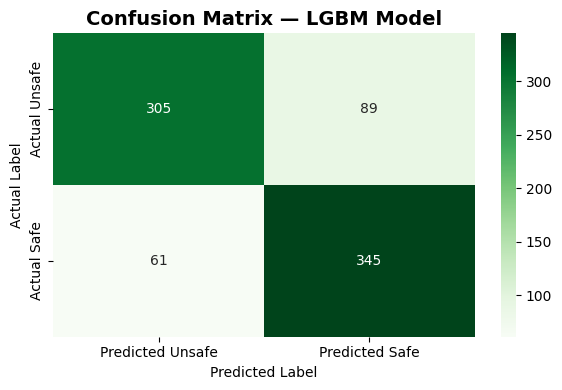

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Unsafe', 'Predicted Safe'],
            yticklabels=['Actual Unsafe', 'Actual Safe'])

plt.title('Confusion Matrix — LGBM Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
